# Propagation Time Sigsbee

In [12]:
import sys, os

basepath = os.path.abspath("../..")
sys.path.append(basepath)
sys.path.append(basepath + "/Operators")
sys.path.append(basepath + "/Utilities")

figdir = basepath + "/Fig/"
datadir = basepath + "/Data/"

# Import the linearized Born modeling operators

In [13]:
import numpy as np
import scipy as sp
from scipy import ndimage
import time
import matplotlib.pyplot as plt
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

import DevitoOperators
from DevitoUtils import create_model, plot_image, plot_image_xy, plot_images_grid_xy, plot_shotrecord
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_velocity, plot_perturbation, demo_model, AcquisitionGeometry

#### Load Sigbsbee full model


Plot of Sigsbee velocity model


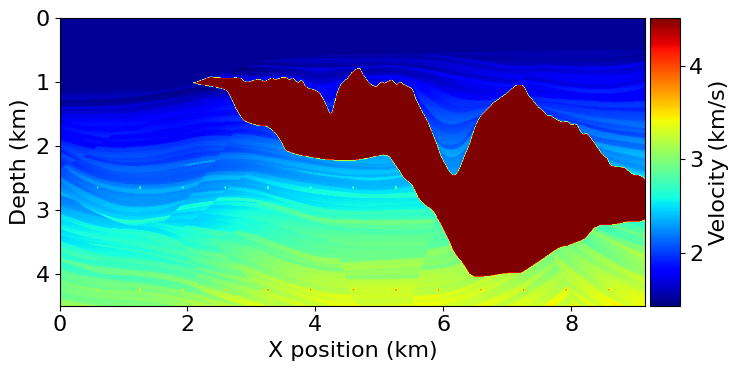

In [14]:
# Create params dicts
params = {
    "Nx": 600,
    "Nz": 200,
    "Nt": 100,   # this has to be updated later
    "nbl": 75,
    "Ns": 20,
    "Nr": 200,
    "so": 4,
    "to": 2
}

vel_sigsbee = np.load(datadir + "sigsbee.npz")["arr_0"]
Nx = vel_sigsbee.shape[0]
Nz = vel_sigsbee.shape[1]

# Create model
sigsbee = create_model(shape=(Nx - 2 * params["nbl"], Nz - 2 * params["nbl"]))
sigsbee.vp.data[:, :] = vel_sigsbee * 0.3048 * 0.001    # This converts velocity to km/s
print("\nPlot of Sigsbee velocity model")
plot_velocity(sigsbee)

del Nx, Nz, vel_sigsbee

## Create model


Plot of background velocity v1


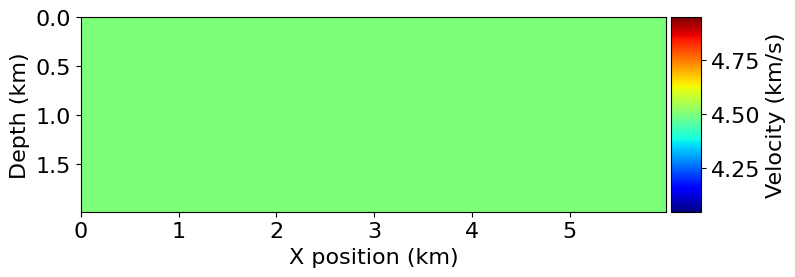


Plot of true velocity v


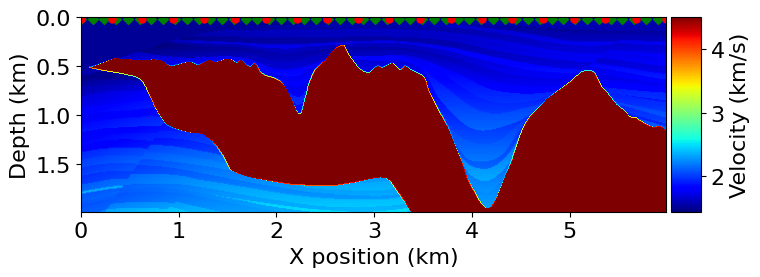

In [20]:
######################################################
# This part of the code creates the models
######################################################

# Specify start index for cropping
start = (200, 50)

# Create cropped model
v = create_model(shape=(params["Nx"], params["Nz"]))
v.vp.data[:, :] = sigsbee.vp.data[start[0]: start[0] + params["Nx"] + 2 * params["nbl"],
                                  start[1]: start[1] + params["Nz"] + 2 * params["nbl"]]

# Create background model
v1 = create_model(shape=(params["Nx"], params["Nz"]))
v1.vp.data[:, :] = 4.5


######################################################################
# This part of the code creates the acquisition geometry, solvers
######################################################################

t0 = 0.
tn = 4000.          # Simulation last 4 second (4000 ms)
f0 = 0.010          # Source peak frequency is 10Hz (0.010 kHz)

# Reflection acquisition geometry (sources and receivers are equally spaced in X direction)
src_depth = 20.0                        # Depth is 20m
rec_depth = 20.0                        # Depth is 20m

src_coord = np.empty((params["Ns"], 2))
if params["Ns"] == 1:
    src_coord[:, 0] = 0.5 * v.domain_size[0]
    src_coord[:, 1] = src_depth
else:
    src_coord[:, 0] = np.linspace(0, v.domain_size[0], num=params["Ns"])
    src_coord[:, 1] = src_depth

rec_coord = np.empty((params["Nr"], 2))
rec_coord[:, 0] = np.linspace(0, v.domain_size[0], num=params["Nr"])
rec_coord[:, 1] = rec_depth

# Create the geometry objects for background velocity models
src_dummy = np.empty((1, 2))

src_dummy[0, :] = src_coord[int(src_coord.shape[0] / 2), :]
geometry = AcquisitionGeometry(v, rec_coord, src_dummy, t0, tn, f0=f0, src_type='Ricker')
params["Nt"] = geometry.nt
del src_dummy

# Define a solver object
solver = AcousticWaveSolver(v, geometry, space_order=params["so"])

# Plot the velocities
print("\nPlot of background velocity v1")
plot_velocity(v1)
print("\nPlot of true velocity v")
plot_velocity(v, source=src_coord, receiver=rec_coord[::4, :])

## Generate data

In [21]:
##################################################################################################
# This part of the code generates the forward data using the two models and computes the residual
##################################################################################################

dt = v.critical_dt

# Allocate numpy arrays to store data
data = np.zeros(shape=(params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)
data1 = data * 0

# Call wave_propagator_forward with appropriate arguments
t_start = time.time()
DevitoOperators.wave_propagator_forward(
    data=data,
    src_coords=src_coord,
    vel=v,
    geometry=geometry,
    solver=solver,
    params=params
)
t_end = time.time()
print("\n Time to model shots for v1 took ", t_end - t_start, " sec.")

t_start = time.time()
DevitoOperators.wave_propagator_forward(
    data=data1,
    src_coords=src_coord,
    vel=v1,
    geometry=geometry,
    solver=solver,
    params=params
)
t_end = time.time()
print("\n Time to model shots for v1_prime took ", t_end - t_start, " sec.")

# Calculate residuals
res = data - data1


 Time to model shots for v1 took  22.872360229492188  sec.

 Time to model shots for v1_prime took  20.487208604812622  sec.



Residuals for model v1 

Shot i =  5


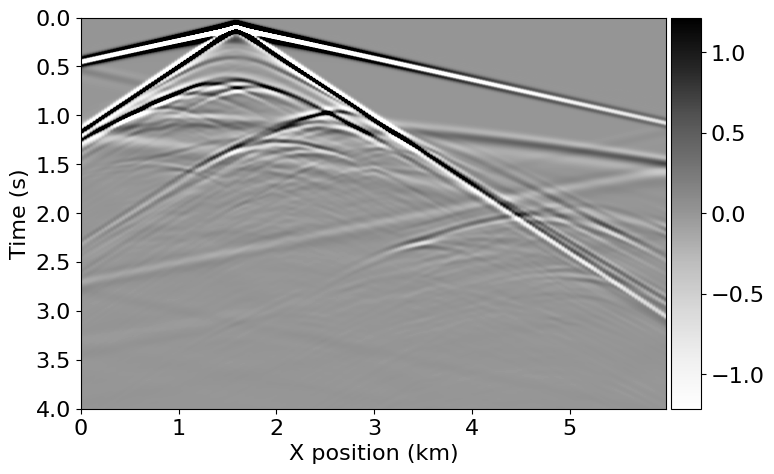

In [22]:
print("\nResiduals for model v1 ")
i = int(params["Ns"] * 0.25)
print("\nShot i = ", i)
plot_shotrecord(res[i, :, :], v1, t0, tn, clip=0.05)

In [23]:
filestr = "p07_sigsbee1_lo_multi_shot"
dm_invert_multi_shot = np.load(datadir + filestr + ".npz")["arr_0"]

In [24]:
td_born_data_inverted_model_multi_shot = np.zeros((params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)

DevitoOperators.td_born_forward(
    model_pert=dm_invert_multi_shot, 
    born_data=td_born_data_inverted_model_multi_shot, 
    src_coords=src_coord, 
    vel=v1, 
    geometry=geometry, 
    solver=solver, 
    params=params,
    dt=dt
)

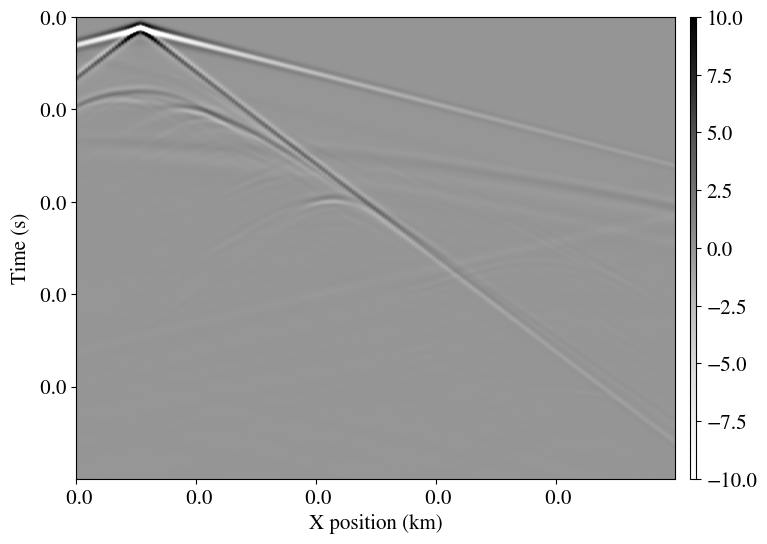

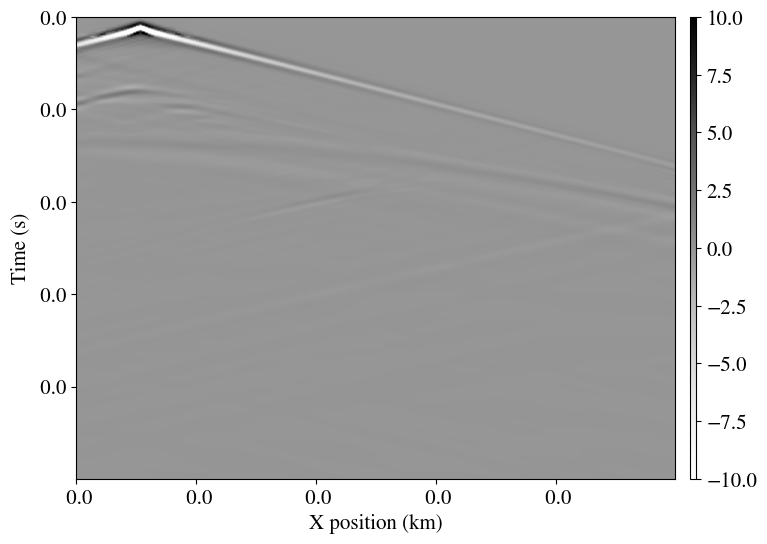

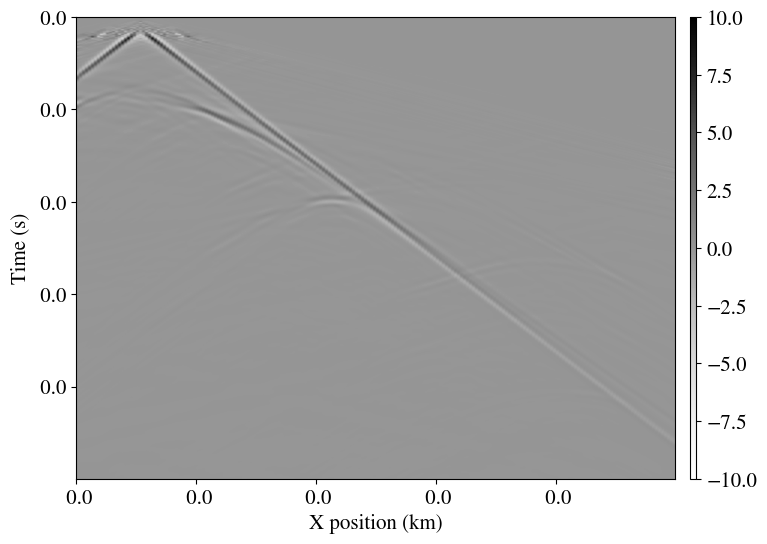

In [31]:
plot_image_xy(image=res[2, :, :], x0=0, xn=6, y0=0, yn=4, scale=10, fontname="STIXGeneral")
plot_image_xy(image=td_born_data_inverted_model_multi_shot[2, :, :], x0=0, xn=6, y0=0, yn=4, scale=10, fontname="STIXGeneral")
plot_image_xy(image=res[2, :, :]-td_born_data_inverted_model_multi_shot[2, :, :], x0=0, xn=6, y0=0, yn=4, scale=10, fontname="STIXGeneral")

In [33]:
filestr = "p07_sigsbee1_lo_multi_shot"
dm_invert_multi_shot = np.load(datadir + filestr + ".npz")["arr_0"]
dm_invert_multi_shot_updated = np.load(datadir + filestr + "_ir0.npz")["arr_0"] + dm_invert_multi_shot

td_born_data_inverted_model_multi_shot_updated = np.zeros((params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)

DevitoOperators.td_born_forward(
    model_pert=dm_invert_multi_shot_updated, 
    born_data=td_born_data_inverted_model_multi_shot_updated, 
    src_coords=src_coord, 
    vel=v1, 
    geometry=geometry, 
    solver=solver, 
    params=params,
    dt=dt
)

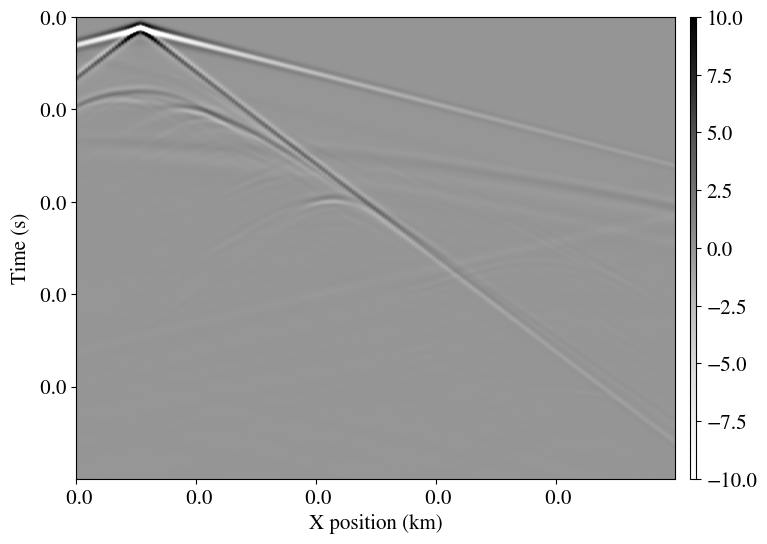

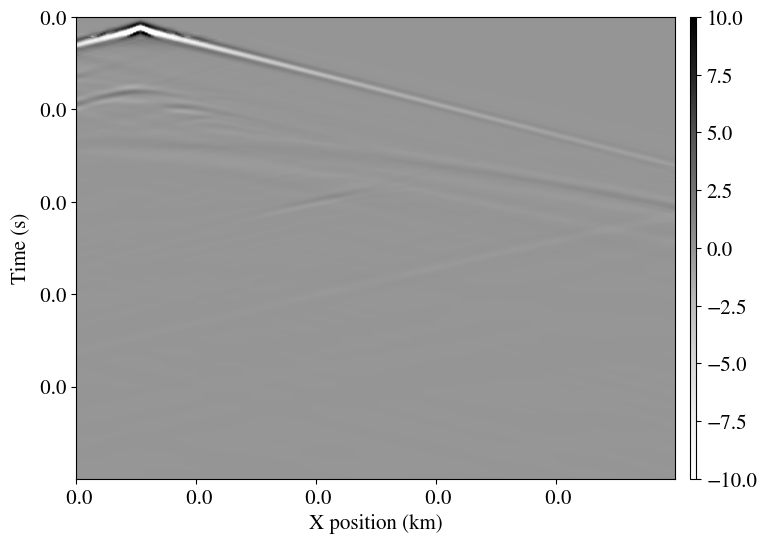

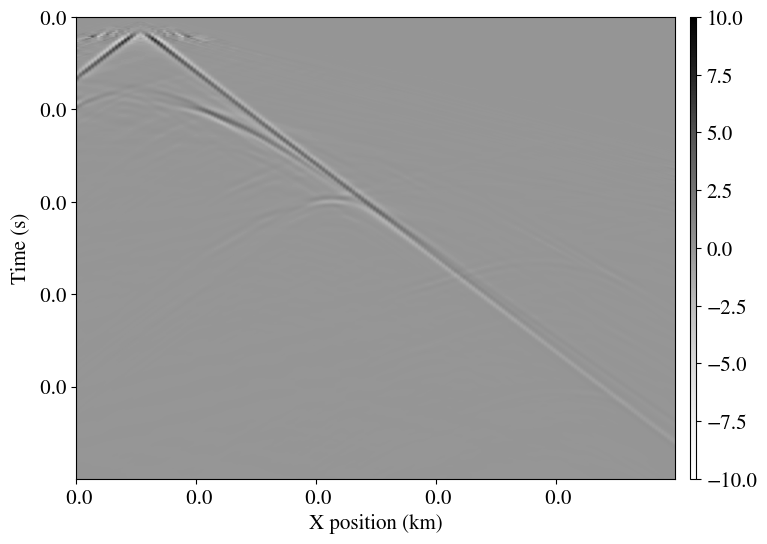

In [34]:
plot_image_xy(image=res[2, :, :], x0=0, xn=6, y0=0, yn=4, scale=10, fontname="STIXGeneral")
plot_image_xy(image=td_born_data_inverted_model_multi_shot_updated[2, :, :], x0=0, xn=6, y0=0, yn=4, scale=10, fontname="STIXGeneral")
plot_image_xy(image=res[2, :, :]-td_born_data_inverted_model_multi_shot_updated[2, :, :], x0=0, xn=6, y0=0, yn=4, scale=10, fontname="STIXGeneral")